In [56]:
import json
from src.data_processing import print_progress, scores_as_matrix, load_data
import numpy as np
from gensim import models
from src.pun_algorithms import is_Tom_Swifty


from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint


import warnings
warnings.filterwarnings('ignore')

In [52]:
#model = models.KeyedVectors.load_word2vec_format("/home/doogy/Data/GoogleNews-vectors-negative300.bin.gz", binary=True)

Load the vectors, dump as binary

In [53]:
task1, task2, task3, min_pairs, strings, pun_strings = load_data()

In [54]:
no_tom_indices = [i for i, context in enumerate(task1) if 'Tom' not in context['words']]

In [55]:
y = np.array([int(context['pun']) for context in task1])

with open("results/tom_swifties.json") as f:
    toms = json.load(f)
    y_toms = [0] * len(task1)
    for i, t1_index in enumerate([c['t1_index'] for c in task2]):
        y_toms[t1_index] = int(bool(toms[i]))
    y_toms = np.array(y_toms)

In [62]:
def test_dataset(X_in, y_in, clf=None, repeats=1000, ytoms=None):

    n_splits=89

    columns = 5
    weight = 1
    report = {'f1-score': 0, 'precision': 0, 'recall': 0, 'support': 0, 'accuracy': 0}
    
    for i in range(repeats):
        print_progress(i, repeats)
        
        kf = KFold(n_splits=n_splits, shuffle=True)
        kf.get_n_splits(X_in)
        
        for train_index, test_index in kf.split(X_in):

            X_train, X_test = X_in[train_index, :columns], X_in[test_index, :columns]
            y_train, y_test = y_in[train_index], y_in[test_index]
            class_weights = class_weight.compute_class_weight('balanced',
                                                         np.unique(y_train),
                                                         y_train)

            class_weight_dict = dict(enumerate(class_weights))
#             class_weight_dict = None
            if clf is None:
                clf = LogisticRegression(class_weight=class_weight_dict)
                clf.fit(X_train, y_train)
                predictions = clf.predict(X_test)

            elif isinstance(clf, list):
                
                # Ensemble time!
                predictions = np.zeros(y_test.shape)

                for c in clf:
                    c.fit(X_train, y_train)
                    predictions += c.predict(X_test)

                predictions = np.around(predictions/len(clf))
                predictions = predictions.astype(int)

            else:
                
                clf.fit(X_train, y_train)
                predictions = clf.predict(X_test)
                
            if ytoms is not None:

                predictions[ytoms[test_index] == 1] = 1
                
            predictions = predictions.astype(int)
                    
            for k, v in classification_report(y_test, predictions, output_dict=True)['1'].items():
                report[k] += v
            report['accuracy'] += (sum(clf.predict(X_test) == y_test) / len(X_test))


    for k in report:
        report[k] /= n_splits * repeats

            
#     print()
#     pprint(report)
    return report
    

In [58]:
locations = (['phonetic_filter_no_pos',
              'phonetic_filter_with_pos',
              'all_trigram_no_pos',
              'all_trigram_with_pos'])

In [17]:
def row_to_string(phonetic, pos, d):
    return (str(phonetic)
            + str(pos)
            + ", " + str(d['accuracy'])
            + ", " + str(d['precision'])
            + ", " + str(d['recall'])
            + ", " + str(d['f1-score']) + "\n")

In [ ]:
with open("results/tables/es/es/classification.json") as f:
    f.write("Phonetic Filter, Use Position, Accuracy, Precision, Recall, F1\n")
    f.write(True, False, pfnp)
    f.write(True, True, pfwp)
    f.write(False, False, atnp)
    f.write(False, True, atwp)

In [64]:
X = scores_as_matrix(locations[0])
test_dataset(X, y, ytoms=y_toms, repeats=100)

 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

{'accuracy': 0.6898202247190961,
 'f1-score': 0.8134784060825854,
 'precision': 0.883642237366052,
 'recall': 0.7634814073641552,
 'support': 14.280898876404494}

In [61]:
X = scores_as_matrix(locations[0])
test_dataset(X, y, ytoms=y_toms, repeats=100)

 |███████████████████████████████████████████████████████████████████████████████████████████████████-| 99.0% 

{'accuracy': 0.689890034073946,
 'f1-score': 0.8161721463911402,
 'precision': 0.887943031577895,
 'recall': 0.7638491171749874,
 'support': 14.280898876404494}

In [15]:
X = scores_as_matrix(locations[2])
test_dataset(X, y, ytoms=y_toms, repeats=1000)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 99.9% 

{'accuracy': 0.7498140449438465,
 'f1-score': 0.8501789832511638,
 'precision': 0.8259908963924304,
 'recall': 0.8852827699854061,
 'support': 14.280898876404494}

In [16]:
X = scores_as_matrix(locations[3])
test_dataset(X, y, ytoms=y_toms, repeats=1000)

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 99.9% 

{'accuracy': 0.756744382022505,
 'f1-score': 0.8538816249739479,
 'precision': 0.8249398393824947,
 'recall': 0.8941984893030724,
 'support': 14.280898876404494}

In [ ]:
results = []
for loc in locations:
    X = scores_as_matrix(loc)
    results.append(test_dataset(X, y, ytoms=y_toms, repeats=1000))

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 99.9% {'accuracy': 0.6895370786516831,
 'f1-score': 0.8133406964256036,
 'precision': 0.8836424563622624,
 'recall': 0.7633681920218285,
 'support': 14.280898876404494}
 |██████████████████████████████████████████████████████████████████████████████████████████████------| 94.1% 

# Tom Swifty pass

In [16]:
sum(y_toms)

211

In [16]:
tom_swifty_y = np.array([int(i) for i in run])

In [20]:
X = scores_as_matrix('all_trigram_with_pos')

 |████████████████████████████████████████████████████████████████████████████████████████████████████| 99.9% 

In [77]:
test_dataset(X, y, clf=SVC(), ytoms=tom_swifty_y, repeats=10)

 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 
{'accuracy': 0.7489325842696621,
 'f1-score': 0.8433119098531224,
 'precision': 0.8193358340628938,
 'recall': 0.8772421092047492,
 'support': 14.280898876404494}


In [61]:
test_dataset(X[tom_swifty_y==0], y[tom_swifty_y==0], repeats=10)

 |██████████████████████████████████████████████████████████████████████████████████████████----------| 90.0% 
{'accuracy': 0.7482448410075643,
 'f1-score': 0.8167785479389352,
 'precision': 0.7867883918974458,
 'recall': 0.8633916925770861,
 'support': 11.910112359550562}


In [60]:
len(X[tom_swifty_y==0])

1566

In [68]:
tom_swifty_y==1

array([ True,  True, False, ..., False, False,  True])

In [70]:
tom_acc = sum(tom_swifty_y[tom_swifty_y==1] == y[tom_swifty_y==1]) / sum(tom_swifty_y==1)

In [72]:
(0.7482448410075643 * (len(X[tom_swifty_y==0]) / len(X))) + (tom_acc * (len(X[tom_swifty_y==1]) / len(X)))

0.7768266410212616

In [71]:
len(X)

1780

In [48]:
X_test = np.array(list(range(20, 45)))
tom_swifty_y[X_test] == 1

array([False,  True,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True, False, False,
       False, False, False, False, False, False, False])

In [47]:
X_test==1

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [15]:
%matplotlib inline

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

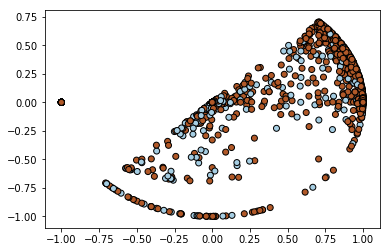

In [17]:
plt.scatter(dataset[:, 0], dataset[:, 1], c=y, cmap=plt.cm.Paired, edgecolors='k')